Alternate Catalog Test 7: 

Version: **13 January 2025**

**Note:** Same as Alternate Catalog 4 (with no k-corrections), but fitting an ellipse in each apparent magnitude bin rather than a global ellipse.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
from astropy.io import fits

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from sklearn.covariance import EllipticEnvelope
from matplotlib.patches import Ellipse
from scipy.stats import chi2

from tqdm import tqdm
from hdbscan import HDBSCAN
from scipy.stats import binned_statistic
from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '../'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_corr-20251030.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.5690596280100633e-05,122.32238811543634,10.869518800965125,N
55,SGA-2020 55,PGC1203

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

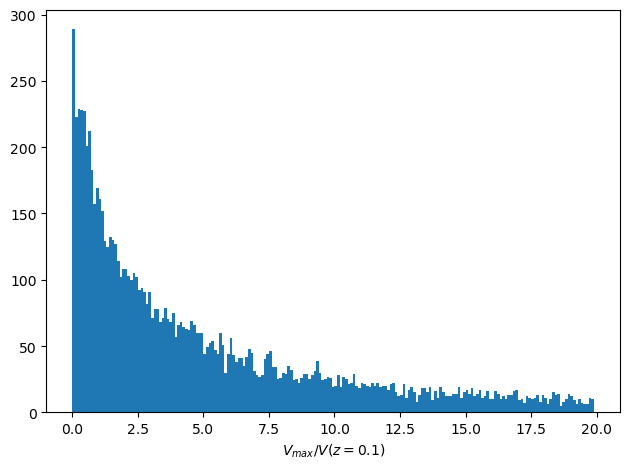

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [7]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [8]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '../'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [9]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [10]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [11]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [12]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [13]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Photometric corrections

### Survey offsets

In [14]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [15]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [16]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [17]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [18]:
# ##### Split the data into 3 regions z<=0.03 to be corrected to z=0.03, z>=0.1 to be corrected to z=0.1,
# ##### and the middle region to have no k-correction

# zg0_low = (sgatab['Z_DESI'] >= 0) & (sgatab['Z_DESI'] <= 0.03) #there are a couple below zero
# zg0_high = (sgatab['Z_DESI'] >= 0.1)

# kcorr_zg0_low = k_corr(sgatab['Z_DESI'][zg0_low], 
#                    [sgatab['G_MAG_SB26'][zg0_low], sgatab['R_MAG_SB26'][zg0_low], sgatab['Z_MAG_SB26'][zg0_low]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_low], sgatab['R_MAG_SB26_ERR'][zg0_low], sgatab['Z_MAG_SB26_ERR'][zg0_low]], 
#                    z_corr=0.03)

# kcorr_zg0_high = k_corr(sgatab['Z_DESI'][zg0_high], 
#                    [sgatab['G_MAG_SB26'][zg0_high], sgatab['R_MAG_SB26'][zg0_high], sgatab['Z_MAG_SB26'][zg0_high]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0_high], sgatab['R_MAG_SB26_ERR'][zg0_high], sgatab['Z_MAG_SB26_ERR'][zg0_high]], 
#                    z_corr=0.1)


# kcorr = np.zeros((len(sgatab), 3))
# kcorr[zg0_low] = kcorr_zg0_low
# kcorr[zg0_high] = kcorr_zg0_high

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [18]:
temp_infile = open('../iron_internalDust_z0p1_mcmc_nokcorr.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [20]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [21]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z

In [22]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0, so that we can fit an ellipse in each redshift bin.

In [23]:
zmin=0
# zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax+dz/2, dz)

zbin_indices = np.digitize(sgatab['Z_DESI_CMB'], zbins, right=True)

binwidth=dz

In [51]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.000    1 galaxies
 1  0.000 < z <= 0.005   42 galaxies
 2  0.005 < z <= 0.010  179 galaxies
 3  0.010 < z <= 0.015  231 galaxies
 4  0.015 < z <= 0.020  315 galaxies
 5  0.020 < z <= 0.025  528 galaxies
 6  0.025 < z <= 0.030  659 galaxies
 7  0.030 < z <= 0.035  882 galaxies
 8  0.035 < z <= 0.040  714 galaxies
 9  0.040 < z <= 0.045  655 galaxies
10  0.045 < z <= 0.050  644 galaxies
11  0.050 < z <= 0.055  638 galaxies
12  0.055 < z <= 0.060  574 galaxies
13  0.060 < z <= 0.065  546 galaxies
14  0.065 < z <= 0.070  532 galaxies
15  0.070 < z <= 0.075  443 galaxies
16  0.075 < z <= 0.080  469 galaxies
17  0.080 < z <= 0.085  427 galaxies
18  0.085 < z <= 0.090  360 galaxies
19  0.090 < z <= 0.095  228 galaxies
20  0.095 < z <= 0.100  219 galaxies
21  z > 0.100  914 galaxies


In [25]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

42 882


# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not an outlier (based on ellipse fit shown below notebook)

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [26]:
def fit_ellipse(x,y):
    X = np.vstack([x, y]).T
    ee = EllipticEnvelope(contamination=0.05, random_state=0)
    ee.fit(X)
    return ee.location_, ee.covariance_

def plot_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Draw a confidence ellipse from mean and covariance.
    n_std=2 ~ 95% for 2D
    """
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    width, height = 2 * n_std * np.sqrt(eigvals)

    ellipse = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        **kwargs
    )
    ax.add_patch(ellipse)

def ellipse_boolean(x,y,n_std):
    X = np.vstack([x, y]).T
    ee = EllipticEnvelope(contamination=0.05, random_state=0)
    ee.fit(X)

    mahal_sq = ee.mahalanobis(X)
    outlier_boolean = mahal_sq > n_std**2
    return outlier_boolean

## Fit an ellipse in each redshift bin

In [27]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

sgatab['MU_ZCMB'] = cosmo.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

In [47]:
sigma = 2.5
mu_x = []
mu_y = []
cov_xx = []
cov_xy = []
cov_yx = []
cov_yy = []
zmin = []
# # fit the lowest bin in absolute magnitude space (if we don't want to start at zero)
# zrow.append(0)
# x = np.log10(sgatab['V_0p4R26'][zbin_indices==0])
# y = sgatab['R_ABSMAG_SB26'][zbin_indices==0]
# ellipse_mean, ellipse_cov = fit_ellipse(x,y)
# # print(ellipse_mean, ellipse_cov)
# mu_x.append(ellipse_mean[0])
# mu_y.append(ellipse_mean[1])
# cov_xx.append(ellipse_cov[0][0]) 
# cov_xy.append(ellipse_cov[0][1]) 
# cov_yx.append(ellipse_cov[1][0]) 
# cov_yy.append(ellipse_cov[1][1]) 


for i in range(1,len(zbins)):
    zmin.append(0.005*(i-1))
    x = np.log10(sgatab['V_0p4R26'][zbin_indices==i])
    y = sgatab['R_MAG_SB26_CORR'][zbin_indices==i]

    ellipse_mean, ellipse_cov = fit_ellipse(x,y)
    # print(ellipse_mean, ellipse_cov)
    mu_x.append(ellipse_mean[0])
    mu_y.append(ellipse_mean[1])
    cov_xx.append(ellipse_cov[0][0]) 
    cov_xy.append(ellipse_cov[0][1]) 
    cov_yx.append(ellipse_cov[1][0]) 
    cov_yy.append(ellipse_cov[1][1]) 

# ## fit the highest bin in absolute magnitude space (if we care about above z=0.1)
# i=len(zbins)
# zrow.append(i)
# x = np.log10(sgatab['V_0p4R26'][zbin_indices==0])
# y = sgatab['R_ABSMAG_SB26'][zbin_indices==0]
# ellipse_mean, ellipse_cov = fit_ellipse(x,y)
# # print(ellipse_mean, ellipse_cov)
# mu_x.append(ellipse_mean[0])
# mu_y.append(ellipse_mean[1])
# cov_xx.append(ellipse_cov[0][0]) 
# cov_xy.append(ellipse_cov[0][1]) 
# cov_yx.append(ellipse_cov[1][0]) 
# cov_yy.append(ellipse_cov[1][1]) 

In [48]:
ellipse_params = Table([zmin, mu_x, mu_y, cov_xx, cov_xy, cov_yx, cov_yy],
    names=['zmin','MU_X', 'MU_Y', 'COV_XX', 'COV_XY', 'COV_YX', 'COV_YY'])

In [49]:
len(ellipse_params)

20

In [50]:
ellipse_params

zmin,MU_X,MU_Y,COV_XX,COV_XY,COV_YX,COV_YY
float64,float64,float64,float64,float64,float64,float64
0.0,1.6609963388408435,14.140976361101798,0.09912487884114293,-0.44782212980192104,-0.44782212980192104,3.3723485201320833
0.005,1.6501901209230205,14.928782404722847,0.08568800025232366,-0.23260548074161758,-0.23260548074161758,1.551984125983037
0.01,1.8312147794671256,15.061118444185828,0.04755015186762496,-0.20423712014245912,-0.20423712014245912,1.2628422456859163
0.015,1.9440176039398394,14.976528239139768,0.04415509294672994,-0.22485546191995945,-0.22485546191995945,1.49666786058101
0.02,1.9838175944164902,15.200443407276595,0.029179791571291015,-0.15185691386755715,-0.15185691386755715,1.0297500034620521
0.025,2.0030749389355975,15.43158973850017,0.026036225036160602,-0.1272921072454466,-0.1272921072454466,0.8597659308369289
0.03,2.0379476498522022,15.542192855351292,0.026393187377471736,-0.11994438435602423,-0.11994438435602423,0.7563448489790315
0.035,2.081940085025963,15.57216000339421,0.019743315542616786,-0.09054576943932449,-0.09054576943932449,0.6156945437451424
0.04,2.1099391871763102,15.567540439388988,0.02009480365899519,-0.0866665616182997,-0.0866665616182997,0.5327877682525688


In [53]:
##### Store the ellipse parameters 

# ellipse_params.write(f'/global/homes/s/sgmoore1/DESI_SGA/TF/Y1/systematic_tests/TF_Y1_v7_ellipse_fit_mr_dz=0.005_zmin=0_params.fits', overwrite=True)
# ellipse_params.write(f'/pscratch/sd/s/sgmoore1/TF/TF_Y1_v7_ellipse_fit_mr_dz=0.005_zmin=0_params.fits', overwrite=True)

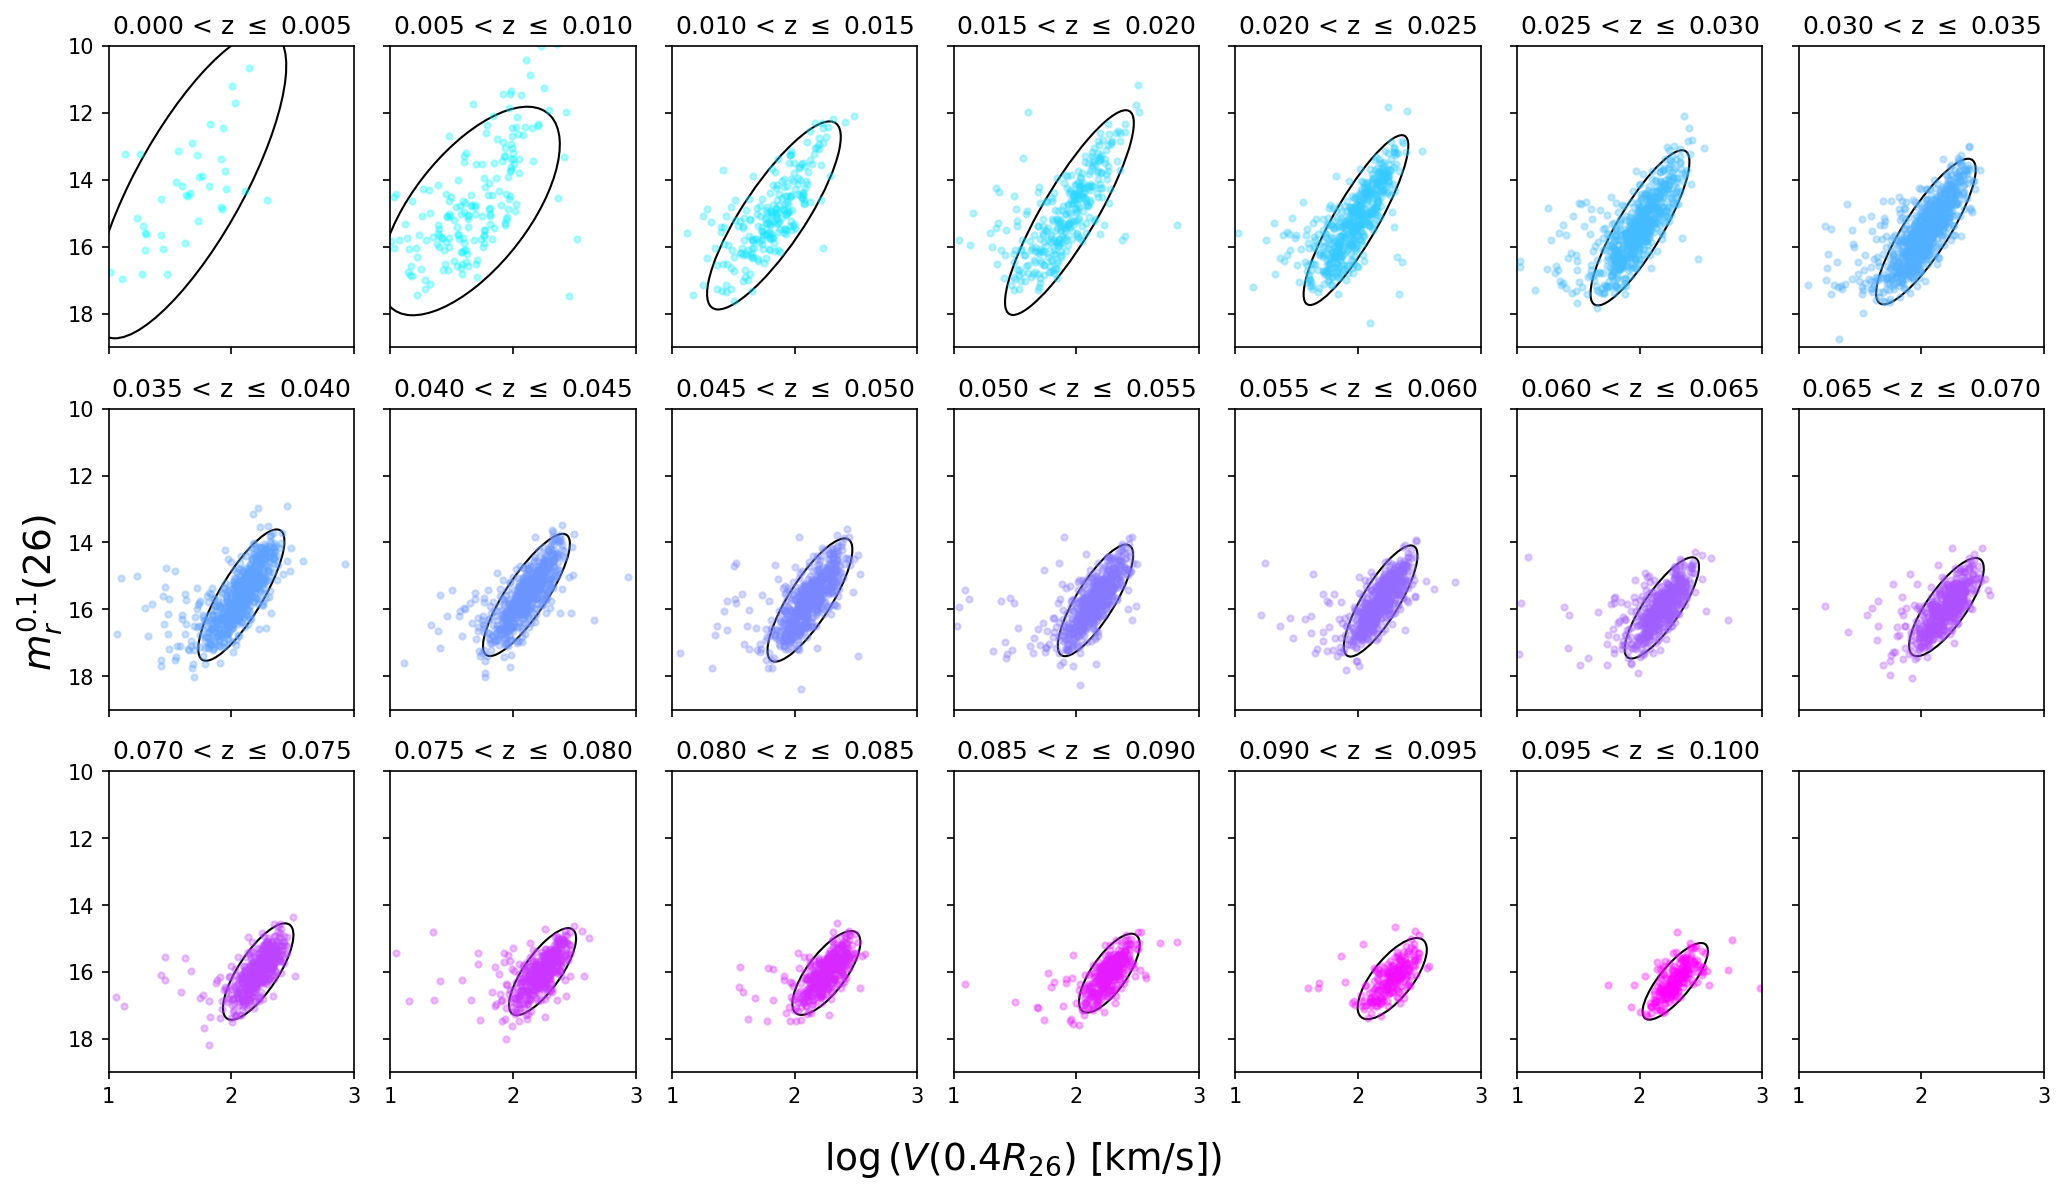

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=7, sharex=True, sharey=True, figsize=(14,8), tight_layout=True,
                        facecolor='none', dpi=150)
# fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)
m = len(mu_x)
color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/7)
    col = i%7
    
    eb = axs[row,col].errorbar(np.log10(sgatab['V_0p4R26'][zbin_indices==i+1]),#+1], 
                               sgatab['R_MAG_SB26_CORR'][zbin_indices==i+1],#+1], 
                               # xerr=sgatab['V_0p4R26_ERR'][zbin_indices==i],#+1], 
                               # yerr=sgatab['R_MAG_SB26_ERR_CORR'][zbin_indices==i],#+1], 
                               fmt='.', color=c, ecolor='lightgray', alpha=0.3)
    # axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    plot_ellipse(mean=(mu_x[i], mu_y[i]), cov = ([cov_xx[i], cov_xy[i]],[cov_yx[i], cov_yy[i]]),
                 n_std = sigma, ax=axs[row,col], edgecolor='k', facecolor='none')

    
    # axs[row,col].set(xlim=[1.5, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {(zbins[i+1] if i+2 < len(zbins) else zmax):.3f}')
    axs[row,col].set(xlim=[1, 3], ylim=[19, 10], title=f'{zbins[i]:.3f} < z $\leq$ {(zbins[i+1] if i+2 < len(zbins) else zmax):.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=18)
fig.supylabel(r'$m_r^{0.1} (26)$', fontsize=18);

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')


In [56]:
outlier_boolean = np.zeros(len(sgatab), dtype=bool)

# ## do the lowest and highest bins separately since they are in absmag space
# bin_mask = (zbin_indices == 0)
# x = np.log10(sgatab['V_0p4R26'][bin_mask])
# y = sgatab['R_ABSMAG_SB26'][bin_mask]
# outlier_bin = ellipse_boolean(x, y, sigma)
# outlier_boolean[bin_mask] = outlier_bin

for i in range(1,len(zbins)):
    bin_mask = (zbin_indices == i)

    x = np.log10(sgatab['V_0p4R26'][bin_mask])
    y = sgatab['R_MAG_SB26_CORR'][bin_mask]

    # Outliers *within this bin*
    outlier_bin = ellipse_boolean(x, y, sigma)

    # Write results back into global array
    outlier_boolean[bin_mask] = outlier_bin

# bin_mask = (zbin_indices == len(zbins))
# x = np.log10(sgatab['V_0p4R26'][bin_mask])
# y = sgatab['R_ABSMAG_SB26'][bin_mask]
# outlier_bin = ellipse_boolean(x, y, sigma)
# outlier_boolean[bin_mask] = outlier_bin

print(np.sum(outlier_boolean)/len(outlier_boolean))

0.10607843137254902


In [57]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~outlier_boolean

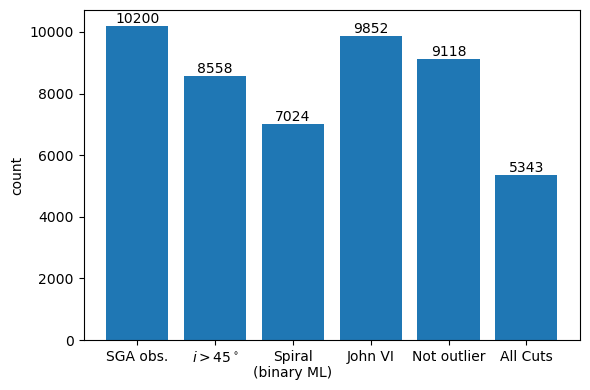

In [58]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    # 'Not dwarf' : np.sum(~dwarf_boolean), 
    'Not outlier' : np.sum(~outlier_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

In [59]:
sgatab_sel = sgatab[is_good_sga]
zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

# Build the Calibration Table of SGA Galaxies

In [60]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
17,0.08162327483927467,38.0,16.908297746704516,0.11122507294232536,122.32238811543634,10.869518800965125
19,0.09120074612338591,117.0,16.069547029314563,0.11457487276780005,180.65572517100514,13.281536295531684
10,0.04770393135250317,1158.0,14.982502191197128,0.109690690518275,177.6605660298364,10.878704878309893
6,0.02726484807614704,1287.0,15.742888009566812,0.06314731186733727,108.65336012925468,19.29462098517713
12,0.05517343391109497,1358.0,14.665805288894662,0.06616048636630542,199.70906692232123,6.994075041243547
13,0.06211147463081468,1548.0,16.590887647230737,0.09790587339599037,169.13249088380044,11.414839425129315
12,0.05541189869150731,1663.0,16.445596950643232,0.13703041235780347,140.65284037083947,10.67103269233122
16,0.07868601783175921,1849.0,15.33591944694519,0.07291888706342384,224.5875972323314,8.330015749448037
10,0.048805933559745496,1996.0,16.822197931903972,0.09047307906106294,125.94703384316176,12.63905939086584


In [61]:
np.max(caltab['Z_DESI_CMB'])

0.09997531472678722

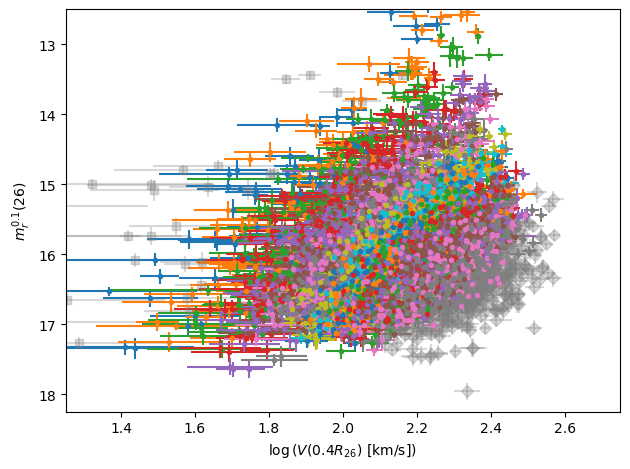

In [119]:
# # fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
# fig, axes = plt.subplots(1, 1, tight_layout=True)

# logV0 = 0

# # ax = axes[0] 
# ax = axes

# #-------------------------------------------------------------------------------
# # Plot galaxies with failed cluster selections.
# #-------------------------------------------------------------------------------
# _zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
# markers = 'sDv^<>'
# for j, _zbin_id in enumerate(_zbin_ids):
#     select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

#     #- Store independent variable for each cluster
#     logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
#     logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

#     #- Store dependent variable for each cluster
#     mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
#     mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

#     if _zbin_id == 0:
#         ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
#                     fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
#                     label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
#     else:
#         ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
#                     fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
#                     label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
# #-------------------------------------------------------------------------------
# # Plot galaxies and clusters passing all selections.
# #-------------------------------------------------------------------------------
# _zbin_ids = np.unique(caltab['Z_BIN_IDX'])

# plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

# for _zbin_id in _zbin_ids:
#     select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

#     #- Store independent variable for each cluster
#     logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
#     logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

#     #- Store dependent variable for each cluster
#     mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
#     mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
#     ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
#                 label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
# #-------------------------------------------------------------------------------

# ax.set(xlim=[1.25, 2.75],
#        xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
#        ylim=[18.25, 12.5],
#        ylabel=r'$m_r^{0.1} (26)$');

# # fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [120]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.157555898831787


## Multiline Fit using HyperFit

In [121]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -1622602.7343575745
     jac: array([-4.14438548, -6.51925748, -0.69849187,  0.5587935 , -8.14907185,
        9.96515072,  0.39581206,  1.79279581,  1.862645  ,  1.95577724,
       -7.42729692, -0.25611369,  0.60535962, 10.45409504,  2.30502318,
        0.13969837, -6.03031317, -3.05008118,  4.81959392, -6.49597496])
 message: 'Optimization terminated successfully.'
    nfev: 72915
     nit: 241
 success: True
       x: array([-6.66494142, 13.0566649 , 13.63602478, 14.13492666, 14.48005667,
       14.83355633, 15.10766776, 15.3183869 , 15.56598649, 15.76695006,
       15.94210874, 16.14839916, 16.29626788, 16.43561935, 16.56173746,
       16.72259757, 16.81336526, 17.01070726, 17.19206332,  0.36999955])
Ndim: 20 18


100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [80.71287703 66.53393715 53.71039505 55.37412141 48.14862057 48.29669564
 44.50709799 59.09714783 62.13289652 56.4935418  71.53658965 65.93204315
 68.67223879 65.52361694 98.28364596 83.1387431  70.40168234 72.44367983
 70.63936332 74.63757089] / 4914.182297896127


100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.91523391  74.91564892  75.89235134  67.68624465  66.86484289
  61.16080692  67.87398262  72.28233642  68.6189441   69.89382113
  81.104619    81.791703    81.95211304  81.08775791  88.21593103
  85.15678006  98.32161934  95.18290259 104.36583433 103.94786889] / 5345.761695383304


100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [132.56533733  92.32386185  85.10461325  71.8400925   70.9973082
  56.34326085  68.69536602  95.08441379  79.33802817  74.97585649
  82.5925048   84.84043997  83.53051964  94.09267978 108.28630116
  95.11268359 108.10444309 113.98332917 118.91891991 119.59583486] / 6628.266866410866


100%|██████████| 1000/1000 [01:13<00:00, 13.69it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [120.7371508   95.22707175  93.24108069  74.82451295  68.17597067
  49.00174562  66.6746923  105.3834344   76.92320575  81.50427619
  94.16221685  83.39904227  95.06901098 101.5665     114.96592192
 101.41995585 115.98646546 127.57425098 126.8336812  129.02294484] / 6451.147241957592


100%|██████████| 1000/1000 [01:12<00:00, 13.89it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [129.84114764 104.53567268  89.38261558  72.99440471  67.54825421
  46.37511032  70.53602344 101.95624668  80.71342896  78.98603198
  98.57123643  90.61228634 105.97197397 109.16646747 109.64643683
 113.6788638  123.89513731 149.76379691 136.00672917 138.37657549] / 7488.1898456548


100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.9146456  117.18437277  94.46339699  74.33287061  72.70845858
  51.62653073  75.1567902   95.65051126  80.81625701  85.18069797
 109.3979616   99.5503713  108.57156215 115.31601261 119.82305935
 117.12776831 146.70661054 148.94240577 146.58189684 157.95948065] / 7897.9740327230875


100%|██████████| 1000/1000 [01:14<00:00, 13.41it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [131.48277159 120.39764337  96.31132925  76.27410132  70.35704878
  50.66226702  78.3980935  101.42759252  87.16124332  81.75575109
 114.5982332  108.3585565  119.36283895 123.99964803 117.50444213
 118.46924715 153.20498837 160.3864164  152.33859192 165.4707337 ] / 8273.53668508087


100%|██████████| 1000/1000 [01:13<00:00, 13.57it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.33003615 119.59464037  98.2765321   83.98706886  67.62727061
  53.60143881  83.78687134  90.30860238  86.77922629  81.5596153
 120.19420366 105.74988519 109.79363792 125.79156135 115.55447974
 129.81165041 160.74754901 175.79274265 155.35474915 163.0681715 ] / 8789.637132468088


100%|██████████| 1000/1000 [01:12<00:00, 13.73it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.3808046  124.62853674  99.98461943  84.20740329  65.63997538
  54.35293408  80.84592034  88.18138182  89.13331926  80.24398471
 119.41910629 110.3982675  114.55372805 131.4572404  110.57138008
 140.54814917 162.9871217  188.60741102 169.33991156 165.9066208 ] / 9430.370551023218


100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [148.3973508  116.35698658 101.1571003   84.33499102  68.91683411
  58.59738691  85.34798573  92.96874504  94.77121211  82.74454235
 115.02274179 116.25068742 116.91905478 142.3291546  112.28501764
 144.47779443 159.3854948  177.38249849 164.39678342 167.12906617] / 8869.124924656882


100%|██████████| 1000/1000 [01:13<00:00, 13.63it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.95091528 115.66219761 103.97072411  84.97203488  67.61006501
  55.14875337  86.73448471  91.94354819  89.91356126  83.93795159
 123.03572428 115.08476253 114.33982189 143.59645384 111.89538717
 141.99423192 160.75962442 183.3915643  163.54908183 173.38706124] / 9169.57821488334


100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.46574908 116.91911188 101.79655098  86.19246377  69.17307749
  57.64685088  85.5269155   98.39736938  88.95294466  87.77804504
 124.54804374 117.3797349  109.77620479 143.4448616  111.24857354
 142.56907394 149.87449575 195.11785425 162.52283755 175.65223674] / 9755.892712717825


100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [150.57432823 127.61370107 102.73994235  88.53580504  72.6937957
  58.85413211  85.44333691  97.44653712  90.55234276  87.72243429
 125.65519859 118.5847878  104.19855169 146.6986679  106.68513289
 145.9111041  150.52039013 183.52034485 168.72155453 171.24216503] / 9176.017242720825


100%|██████████| 1000/1000 [01:13<00:00, 13.64it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.18566293 133.59837501 104.17247679  89.79065131  73.42042548
  61.33995268  83.40390988  96.10410858  94.25048943  88.87310273
 125.39196867 115.7637231   98.66284139 146.00031127 106.15563441
 149.11253499 152.53527    178.20639855 173.29656969 177.0965496 ] / 8910.319927645303


100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [151.9900242  138.29310795 108.80054206  90.34001406  73.6958841
  59.96342214  82.59453698  96.84455693  91.37922285  92.50396309
 124.42375749 116.93102912 100.36678814 148.99411514 111.68882967
 140.38193345 155.48256019 180.33238251 177.05776212 179.59473148] / 9016.619125463661


100%|██████████| 1000/1000 [01:12<00:00, 13.72it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [157.1933145  139.77583436 107.24975764  91.83233919  78.39904777
  61.08914402  83.07181895  97.8045646   86.85655096  93.05063431
 128.50143037 119.48207244 101.07065138 152.28853135 112.58246563
 140.3663624  156.89816157 186.14035334 181.10430402 177.20798581] / 9307.017666893858


100%|██████████| 1000/1000 [01:12<00:00, 13.80it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [168.83175991 148.54620554 108.72751803  90.14699274  78.17674266
  62.10097881  81.51072017  97.15862882  83.57258573  94.47580857
 132.798492   117.99521    100.99670733 157.98715467 114.08553882
 141.29459909 158.04107654 184.16871994 183.17751586 190.10700876] / 9505.350437807529


100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [168.16678005 148.71569546 109.63265656  91.56492326  80.05647992
  64.58400396  82.51188213  99.74837709  84.24007755  94.23017658
 133.6646894  119.51613285 100.96140572 159.0232918  124.65668908
 138.87897744 160.61883718 185.19645295 184.89904546 192.99093385] / 9649.546692659185


100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [171.78760983 144.79790109 107.85490102  92.53852067  78.00742836
  62.85376954  81.38373131 102.32790013  84.17620614  95.55155604
 134.47655485 117.59799647 102.89344289 154.47064153 127.96689992
 140.7764445  161.03540547 187.9464645  188.55022305 197.3802835 ] / 9869.014174874847


In [122]:
temp_outfile = open('/pscratch/sd/s/sgmoore1/TF/pickles/cov_ab_iron_jointTFR_systematics_test_v7-lowcal.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

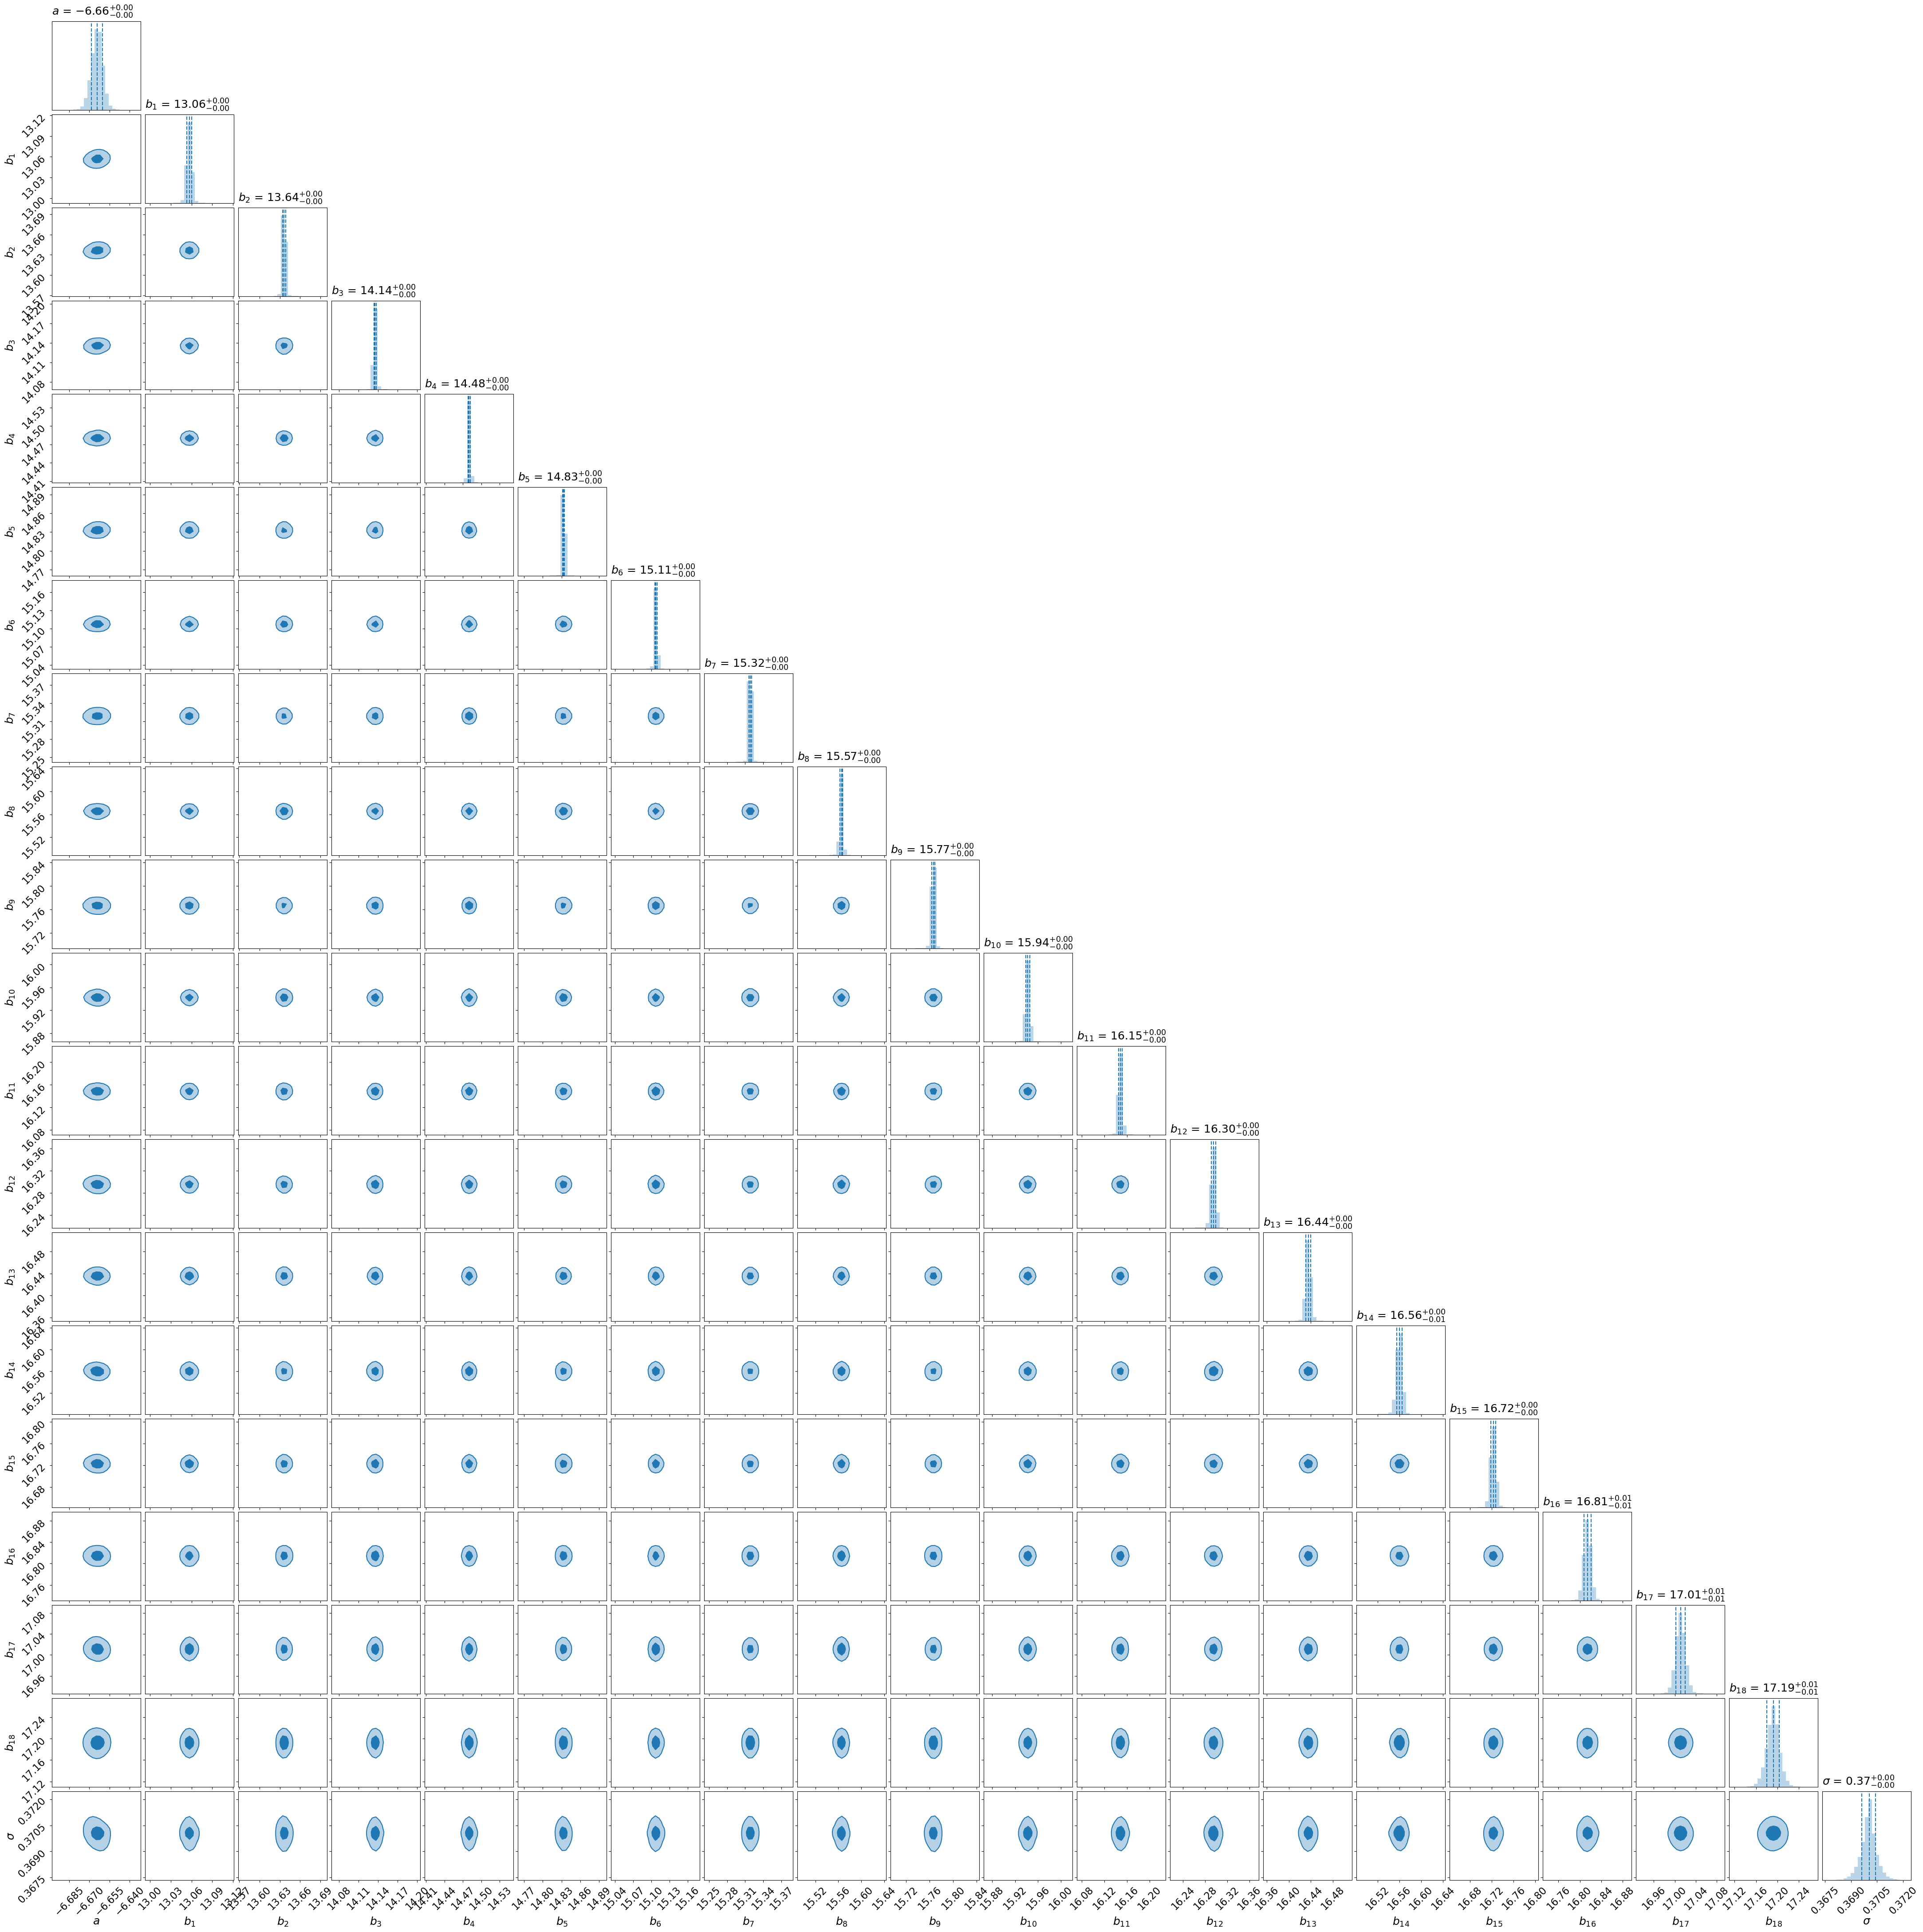

In [123]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [124]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
# for k in range(1, m+2):
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

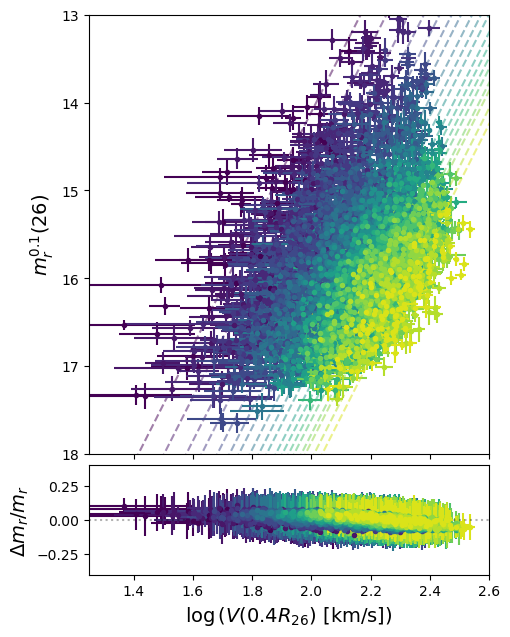

In [125]:
# fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
# b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1]#[1:]

#- Plot redshift bins
# ax = axes[0,0]
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],#+1], 
                     y=mag[k],#+1], 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);
'''
#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)
'''
#- Plot residuals: z-bins
# ax = axes[1,0]
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]#+1]
    m_obs = mag[k]#+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],#+1], 
                     yerr=mag_err[k],#+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)
'''
#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)
'''
fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [155]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.67 +/- 0.002


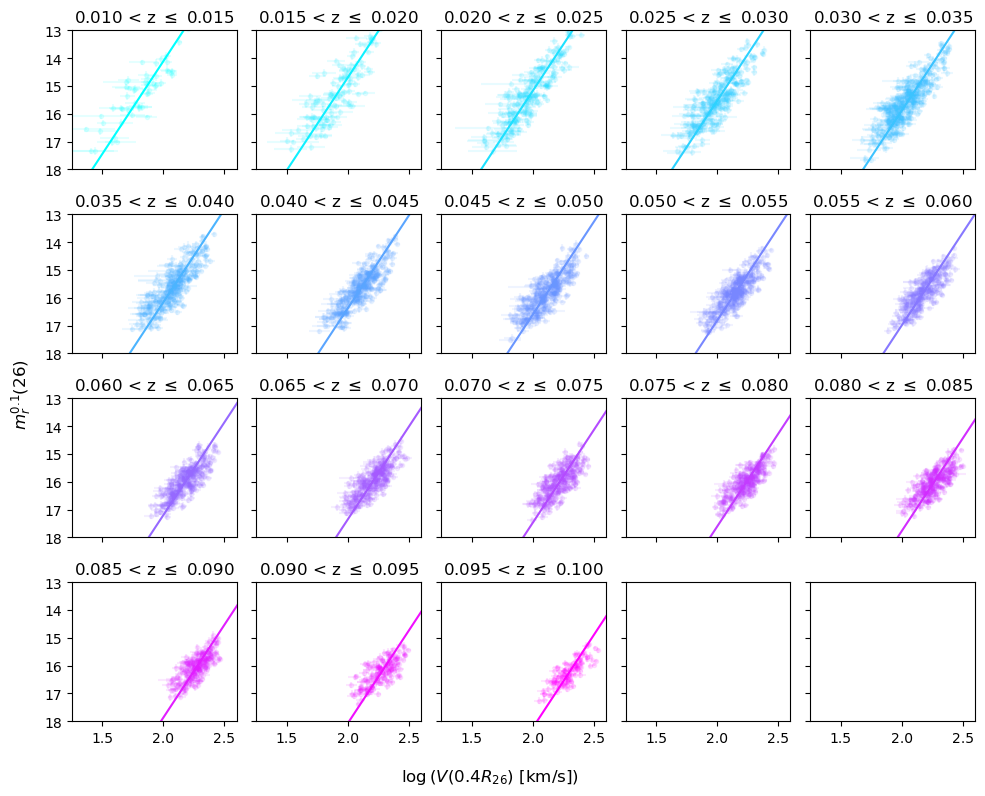

In [128]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

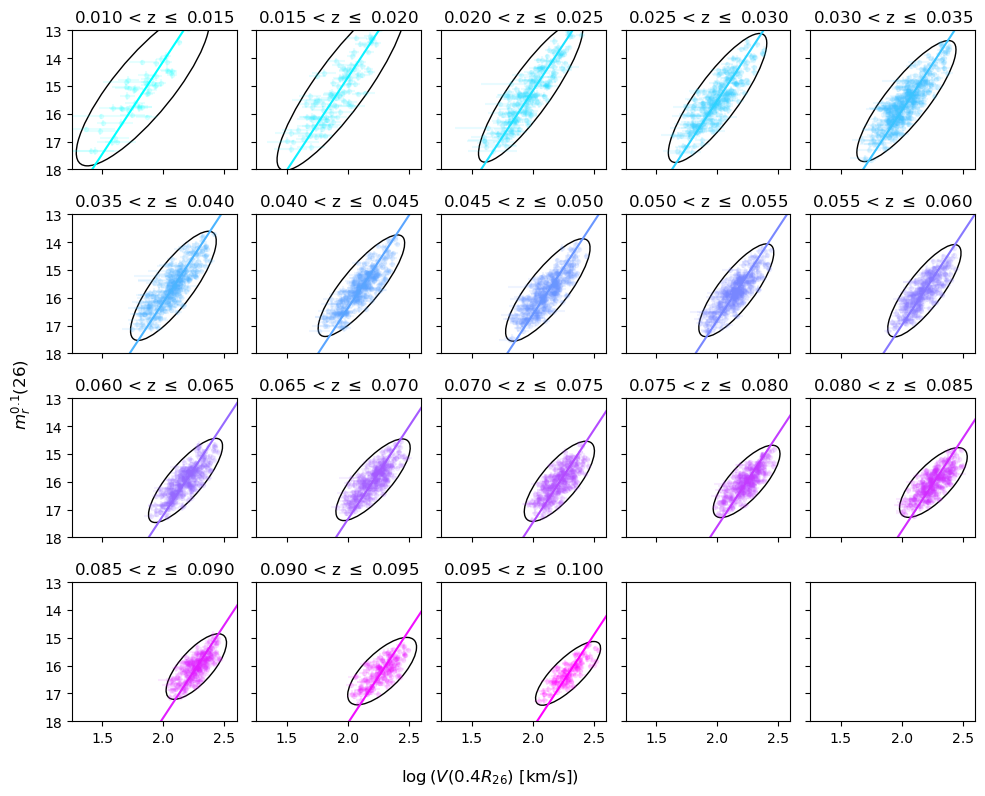

In [153]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/5)
    col = i%5
    
    eb = axs[row,col].errorbar(logV0 + logV[i],#+1], 
                               mag[i],#+1], 
                               xerr=logV_err[i],#+1], 
                               yerr=mag_err[i],#+1], 
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    plot_ellipse(mean=(mu_x[i], mu_y[i]), cov = ([cov_xx[i], cov_xy[i]],[cov_yx[i], cov_yy[i]]),
                 n_std = sigma, ax=axs[row,col], edgecolor='k', facecolor='none')
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

# Calculate logdistance ratios

In [130]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)
# cosmo = DESI()

sgatab['MU_ZCMB'] = cosmo.distmod(sgatab['Z_DESI_CMB'])

sgatab['R_ABSMAG_SB26'] = sgatab['R_MAG_SB26_CORR'] - sgatab['MU_ZCMB'].value

In [131]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(sgatab['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(sgatab['Z_DESI_CMB'][i]), 
                               sgatab['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

sgatab['MU_ZCMB_ERR'] = mu_err

sgatab['R_ABSMAG_SB26_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['MU_ZCMB_ERR'].value**2)

100%|██████████| 10200/10200 [00:09<00:00, 1068.48it/s]


In [152]:
# Center redshift values of each bin
zmin = 0.01
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax+dz/2, dz)
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [133]:
slope = np.median(tfr_mcmc_samples[0])
slope_err = np.sqrt(cov_tfr[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
ZP = np.median(tfr_mcmc_samples[1:-1], axis=1) - mu_zc.value
ZP_err = np.sqrt(np.diagonal(cov_tfr[1:-1,1:-1])) # Should include z-bin width to this uncertainty

sig = np.median(tfr_mcmc_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
absmag = slope*(logv - logV0) + ZP

In [134]:
spiral_boolean = sgatab['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = sgatab['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = sgatab['MORPHTYPE_AI'] == 'Other'

VI_boolean = sgatab['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [135]:
sgatab['GOOD_MORPH'] = morph_boolean

print(sum(outlier_boolean), 'outliers')
print(sum(~outlier_boolean), 'non-outliers')
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & outlier_boolean), 'outliers')
print(np.sum(morph_boolean & ~outlier_boolean), 'non-outliers')

1191 outliers
9009 non-outliers
-----------
9212 spirals & irregulars that pass VI
965 outliers
8247 non-outliers


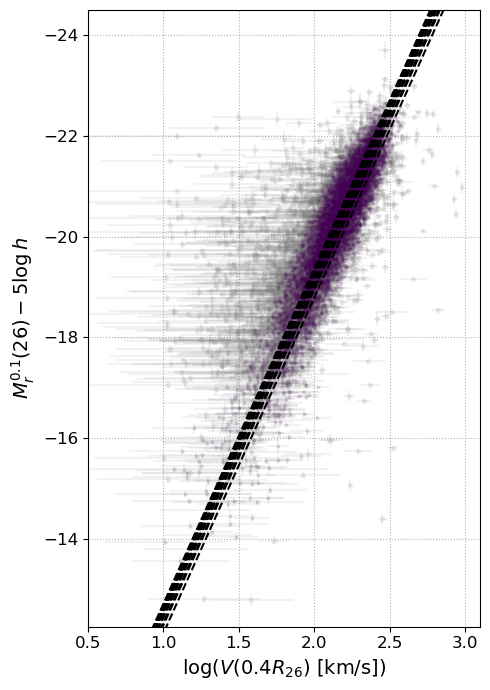

In [136]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
             sgatab['R_ABSMAG_SB26'][sample], 
             xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
             yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

# sample = ~outlier_boolean_alt & outlier_boolean
# plt.errorbar(np.log10(sgatab['V_0p4R26'][sample]), 
#              sgatab['R_ABSMAG_SB26'][sample], 
#              xerr=0.434*sgatab['V_0p4R26_ERR'][sample]/sgatab['V_0p4R26'][sample],
#              yerr=sgatab['R_ABSMAG_SB26_ERR'][sample], 
#              fmt='.', 
#              markersize=4, 
#              alpha=0.2, 
#              ecolor='gray')



plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

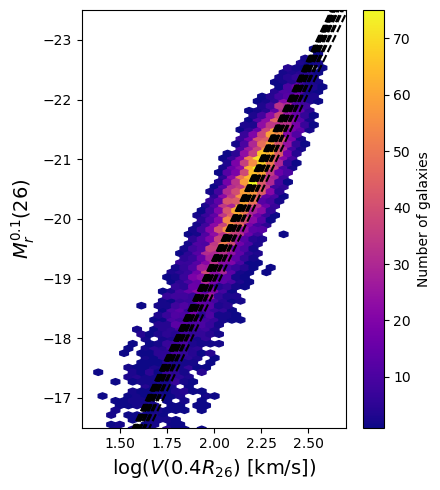

In [137]:
plt.figure(figsize=(4.5,5), tight_layout=True)

plt.hexbin(np.log10(sgatab['V_0p4R26'][~outlier_boolean]), 
           sgatab['R_ABSMAG_SB26'][~outlier_boolean], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, absmag, 'k--', zorder=3)

plt.xlim([1.3, 2.7])
plt.ylim([-16.5, -23.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

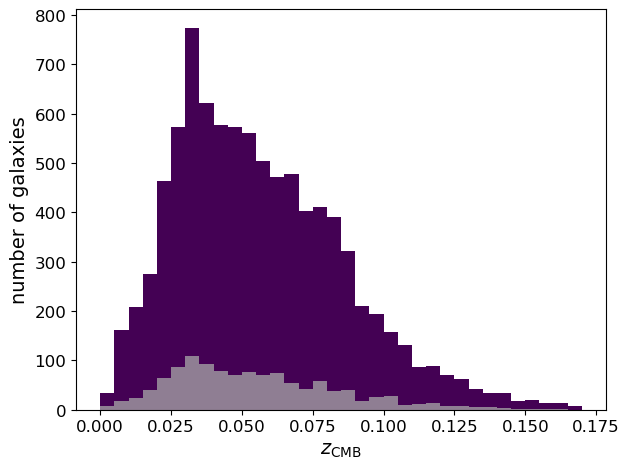

In [138]:
plt.figure(tight_layout=True)

plt.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
         bins=np.arange(0, 0.175, 0.005))
plt.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

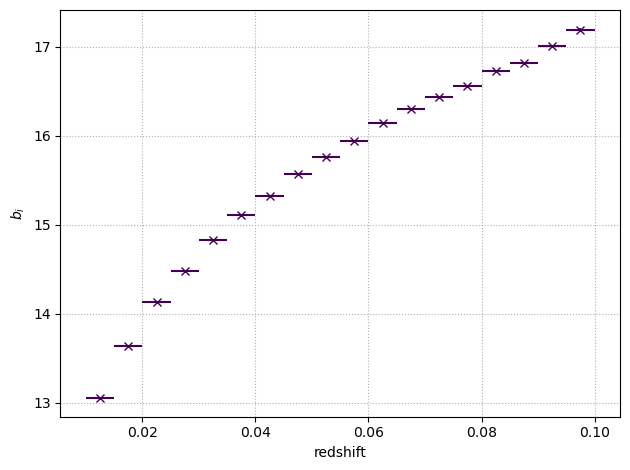

In [154]:
plt.figure(tight_layout=True)

plt.grid(ls=':')

plt.errorbar(zc, np.median(tfr_mcmc_samples[1:-1], axis=1), 
             xerr=0.5*dz, 
             yerr=ZP_err, 
             fmt='x')

# plt.xlim(0.028, 0.102)
# plt.ylim(-20.5, -20.7)

plt.xlabel('redshift')
plt.ylabel('$b_i$');

# Distance moduli

In [139]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(sgatab['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
sgatab['R_ABSMAG_SB26_TF'] = np.nan
for i in range(len(sgatab)):
    sgatab['R_ABSMAG_SB26_TF'][i] = slope*(np.log10(sgatab['V_0p4R26'][i]) - logV0) + ZP[zbin_indices[i] - 1]

In [140]:
sgatab['R_ABSMAG_SB26_TF_ERR'] = np.nan
sgatab['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(sgatab))):
    
    v_random = rng.normal(sgatab['V_0p4R26'][i], 
                          sgatab['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(sgatab['V_0p4R26'][i]), 
    #                          0.434*sgatab['V_0p4R26_ERR'][i]/sgatab['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = slope*(np.log10(v_random[v_random > 0]) - logV0) + ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    sgatab['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
sgatab['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(sgatab['R_ABSMAG_SB26_TF_ERR']**2 - sgatab['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 10200/10200 [00:03<00:00, 2555.27it/s]


In [141]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

/tmp/ipykernel_291463/3818747994.py:50: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


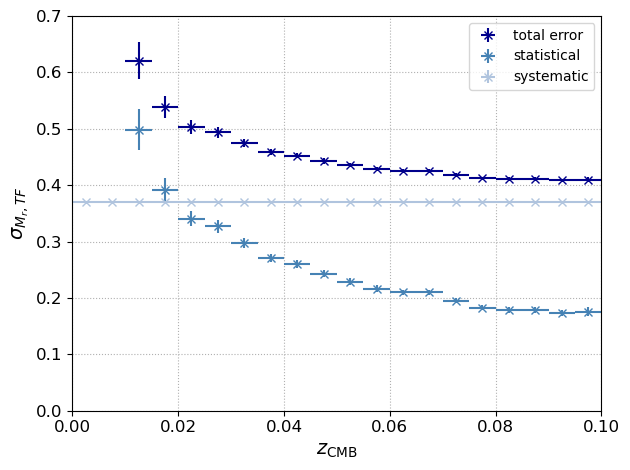

In [142]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [143]:
sgatab['MU_TF'] = sgatab['R_MAG_SB26_CORR'] - sgatab['R_ABSMAG_SB26_TF']

sgatab['MU_TF_ERR'] = np.sqrt(sgatab['R_MAG_SB26_ERR_CORR']**2 + sgatab['R_ABSMAG_SB26_TF_ERR']**2)

## $\Delta M_r$ v. redshift

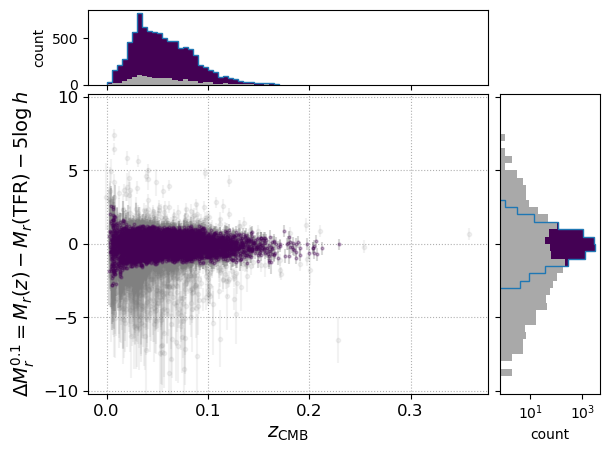

In [144]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

sample = outlier_boolean# & morph_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean
ax.errorbar(sgatab['Z_DESI_CMB'][sample], 
             sgatab['R_ABSMAG_SB26'][sample] - sgatab['R_ABSMAG_SB26_TF'][sample], 
             xerr=sgatab['ZERR_DESI'][sample], 
             yerr=sgatab['MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_r(z) - M_r(\text{TFR}) - 5\log h$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
sample1 = ~outlier_boolean
sample2 = outlier_boolean
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample2] - sgatab['R_ABSMAG_SB26_TF'][sample2], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['R_ABSMAG_SB26'][sample1] - sgatab['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

## $\eta$ v. redshift

In [145]:
sgatab['LOGDIST'] = 0.2*(sgatab['MU_ZCMB'] - sgatab['MU_TF'])
sgatab['LOGDIST_ERR'] = 0.2*np.sqrt(sgatab['MU_ZCMB_ERR']**2 + sgatab['MU_TF_ERR']**2)

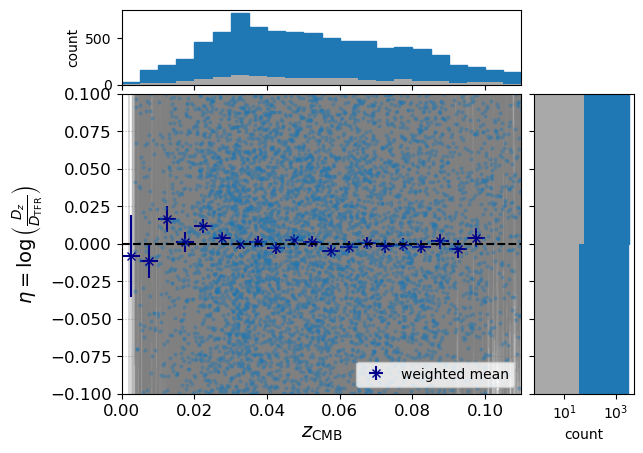

In [146]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(sgatab['Z_DESI_CMB'][sample2], 
             sgatab['LOGDIST'][sample2], 
             xerr=sgatab['ZERR_DESI'][sample2], 
             yerr=sgatab['LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(sgatab['Z_DESI_CMB'][sample1], 
             sgatab['LOGDIST'][sample1], 
             xerr=sgatab['ZERR_DESI'][sample1], 
             yerr=sgatab['LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3,
             color='tab:blue',
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['LOGDIST'][sample1], 
                                    zbins, 
                                    weights=sgatab['LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(sgatab['Z_DESI_CMB'][sample1], 
                                    sgatab['R_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              color='tab:blue',
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(sgatab['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(sgatab['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1),
              color='tab:blue',
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(sgatab['LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

In [147]:
# Create a single column to denote which objects should be used for cosmological analysis
sgatab['OUTLIER'] = outlier_boolean
sgatab['MAIN'] = ~sgatab['OUTLIER'] & sgatab['GOOD_MORPH']

In [148]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = slope
hdr['M_ERR'] = slope_err
# hdr['0PT'] = ZP
# hdr['0PT_ERR'] = ZP_err
hdr['logV0'] = logV0
hdr['SIG'] = np.median(tfr_mcmc_samples[-1])
hdr['SIG_ERR'] = np.sqrt(cov_tfr[-1,-1])
hdr['H0'] = H0

hdr['EL_STD'] = sigma

# hdr['EL_MU_X'] = ellipse_mean[0]
# hdr['EL_MU_Y'] = ellipse_mean[1]

# # Ellipse covariance matrix
# hdr['EL_COV00'] = ellipse_cov[0, 0]
# hdr['EL_COV01'] = ellipse_cov[0, 1]
# hdr['EL_COV10'] = ellipse_cov[1, 0]
# hdr['EL_COV11'] = ellipse_cov[1, 1]


empty_primary = fits.PrimaryHDU(header=hdr)

In [149]:
# table_hdu = fits.BinTableHDU(data=sgatab)

# hdul = fits.HDUList([empty_primary, table_hdu])

# # Write results to file
# hdul.writeto('/global/homes/s/sgmoore1/DESI_SGA/TF/Y1/systematic_tests/SGA_iron_jointTFR_v7-lowcal.fits', 
#              overwrite=True)

In [265]:
# hdul.writeto('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/systematic_tests/DESI-DR1_TF_pv_test_cat_v7.fits', 
#              overwrite=True)